Development of autoencoders with a time-forward map in the loss function 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp

import keras
import jax_cfd.base as cfd
import jax_cfd.spectral as spectral

from typing import Callable

In [17]:
keras.backend.backend()

'jax'

Objective 1: create trajectory function from JAX-CFD spectral

In [3]:
def kolmogorov_ck13_step(Re, grid, smooth=True):
  wave_number = 4
  offsets = ((0, 0), (0, 0))
  # pylint: disable=g-long-lambda
  forcing_fn = lambda grid: cfd.forcings.kolmogorov_forcing(
      grid, k=wave_number, offsets=offsets)
  return spectral.equations.NavierStokes2D(
      1. / Re,
      grid,
      drag=0.0,
      smooth=smooth,
      forcing_fn=forcing_fn)

def generate_time_forward_map(
    dt: float,
    Nt: int,
    grid: cfd.grids.Grid,
    Re: float
) -> Callable[[jnp.ndarray], jnp.ndarray]:
  
  step_fn = spectral.time_stepping.crank_nicolson_rk4(
    kolmogorov_ck13_step(Re, grid, smooth=True), dt)

  time_forward_map = cfd.funcutils.repeated(jax.remat(step_fn), steps=Nt)
  return jax.jit(time_forward_map)

def generate_trajectory_fn(
    Re: float,
    T: float,
    dt_stable: float,
    grid: cfd.grids.Grid,
    t_substep: float=1.
) -> Callable[[jnp.ndarray], jnp.ndarray]:
    N_steps_total = jnp.floor(T / dt_stable)
    dt_exact = T / N_steps_total

    N_steps_per_substep = jnp.floor(t_substep / dt_exact)
    N_substeps = N_steps_total // N_steps_per_substep

    sub_step_fn = generate_time_forward_map(dt_exact, N_steps_per_substep, grid, Re)

    trajectory_fn = jax.jit(cfd.funcutils.trajectory(jax.remat(sub_step_fn), N_substeps))
    return trajectory_fn

Test functionality 

In [4]:
# setup problem and create grid
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 128
Ny = 128
Re = 40.
vort_max = 25. # used to normalize fields in training 

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))

# estimate stable time step based on a "max velocity" using CFL condition
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1./Re, grid) / 2.

In [5]:
trajectory_fn = generate_trajectory_fn(Re, 5.01, dt_stable, grid)

Create a random initial condition and march forward...

In [6]:
import numpy as np

seed = np.random.randint(1e4)
v_random = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed), grid, 5.)
vorticity_random = cfd.finite_differences.curl_2d(v_random).data
vorticity_random_rft = jnp.fft.rfftn(vorticity_random)

In [7]:
_, vort_traj_rft = trajectory_fn(vorticity_random_rft)

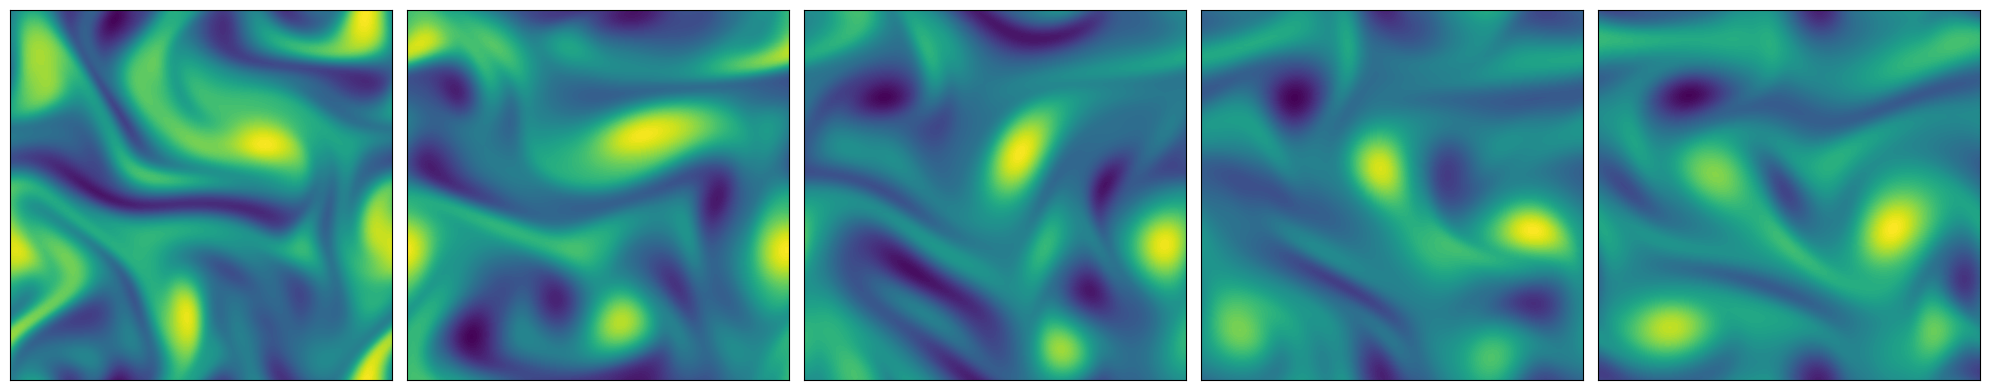

In [8]:
import matplotlib.pyplot as plt

num_axes = len(vort_traj_rft)

fig = plt.figure(figsize=(4 * num_axes, 4))
ax_num = 1
for vort_rft in vort_traj_rft:
  ax = fig.add_subplot(1, num_axes, ax_num)
  ax.contourf(jnp.fft.irfftn(vort_rft).T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

Objective 2: Create an autoencoder loss that includes a component coming from time advancement of the initial condition

In [9]:
def mse_and_traj(vort_true: jnp.ndarray, 
                 vort_pred: jnp.ndarray, 
                 trajectory_rollout_fn: Callable[[jnp.ndarray], jnp.ndarray],
                 vort_max=25.):
  """ Trajectory fn expects real input and gives real output (i.e. fields in physical space)"""
  squared_errors_recon = (vort_true - vort_pred) ** 2

  # NB vort has been normalized by vort_max for prediction
  true_traj = trajectory_rollout_fn(vort_true * vort_max)
  pred_traj = trajectory_rollout_fn(vort_pred * vort_max)
  squared_errors_traj = (true_traj / vort_max - pred_traj / vort_max) ** 2
  return jnp.mean(squared_errors_recon) + jnp.mean(squared_errors_traj)

In [10]:
from functools import partial 

def real_to_real_traj_fn(vort_phys, traj_fn):
  vort_rft = jnp.fft.rfftn(vort_phys)
  _, traj_rft = traj_fn(vort_rft)
  traj_phys = jnp.fft.irfftn(traj_rft, axes=(1,2))
  return traj_phys

real_traj_fn = partial(real_to_real_traj_fn, traj_fn=trajectory_fn)
loss_fn = jax.jit(partial(mse_and_traj, trajectory_rollout_fn=real_traj_fn))

Test raw functionality (i.e. scalar loss?)

In [11]:
seed = np.random.randint(1e4)
v_random_2 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed), grid, 5.)
vorticity_random_2 = cfd.finite_differences.curl_2d(v_random_2).data

In [12]:
loss = loss_fn(vorticity_random, vorticity_random_2)

In [13]:
loss 

Array(nan, dtype=float32)

Works as expected, so the goal now is to couple this to the autoencoder model and take gradients, attempting to pass the custom loss in the usual way. 

The wiggle may be that we struggle to batch because of calls to the time-forward map. JAX-CFD implementation or similar may help there but that uses a different NN library

In [14]:
import models 
ae_model = models.ae_densenet_v7(Nx, Ny, 128)
ae_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=loss_fn, 
    metrics=[keras.losses.MeanSquaredError()]
)

In [15]:
# test on a small subset of training data 
data_loc = '/Users/jpage2/code/jax-cfd-data-gen/Re40test/'
file_front = 'vort_traj.'
files = [data_loc + file_front + str(n).zfill(4) + '.npy' for n in range(10)]

training_data = [np.load(file_name) for file_name in files]
training_data_ar = np.concatenate(training_data, axis=0) / vort_max
training_data_ar.shape

(1000, 128, 128)

In [ ]:
ae_model.fit(training_data_ar[:16], training_data_ar[:16], batch_size=4, epochs=100)

Would now like to try and use our old Dataset object -- whether or not we can use the .map feature with raw tf functions remains to be seen. 

In [16]:
import tensorflow as tf

In [28]:
import glob

def load_npy_file(file_path):
  data = np.load(file_path.decode())
  return data.astype(np.float32)

def tf_load_npy(file_path):
  data = tf.py_function(load_npy_file, [file_path], Tout=np.float32)
  data.set_shape([Nx, Ny])
  return data

file_paths = glob.glob("/Users/jpage2/code/jax-cfd-data-gen/Re40test/*.npy")
file_paths_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = file_paths_dataset.map(lambda file_path: tf_load_npy(file_path), num_parallel_calls=tf.data.AUTOTUNE)

TypeError: DatasetV2.from_tensor_slices() got an unexpected keyword argument 'train_frac'

In [26]:
batch_size = 16
dataset.batch(batch_size)

<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None)>